In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [16]:
outpath = "/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/notebooks/output/supplemental_figures/"

In [29]:
df_ss2 = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/data/HLCA_smartseq_P2_with_postprocessing.pq",columns = ["juncPosR1A","juncPosR1B","chrR1A"])

In [30]:
df_10x = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/data/HLCA4_P2_10x_with_postprocessing_lung.pq",columns = ["juncPosR1A","juncPosR1B","chrR1A"])

In [31]:
df_ss2["junc"] = df_ss2["chrR1A"] + "_" + df_ss2["juncPosR1A"].astype(str) + "_"  + df_ss2["juncPosR1B"].astype(str)

In [32]:
df_ss2.shape[0]

38145051

In [33]:
df_ss2.shape[0]

38145051

In [34]:
df_10x["junc"] = df_10x["chrR1A"] + "_" + df_10x["juncPosR1A"].astype(str) + "_"  + df_10x["juncPosR1B"].astype(str)

In [35]:
len(set(df_ss2["junc"]).intersection(set(df_10x["junc"])))

360731

In [36]:
len(set(df_ss2["junc"]))

4726765

In [37]:
len(set(df_10x["junc"]))

2828355

In [38]:
in_path = "/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/scripts/output/rijk_zscore/"
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
dfs = []

z_cols = ["scZ","svd_z0","svd_z1","svd_z2"]
sig_genes = []
for dataname in datanames:
  print(dataname)
  df = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(in_path, dataname),columns=["ontology","geneR1A_uniq","scZ","svd_z0","svd_z1","svd_z2","cell_gene"])
  sig = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/scripts/output/variance_adjusted_permutations/{}_pvals_100_S_0.1_z_0.0_b_5.tsv".format(dataname),sep="\t")
  sig_genes.append(set(sig[sig["perm_pval_adj_scZ"] < 0.05]["geneR1A_uniq"].unique()))
  df = df.drop_duplicates("cell_gene")
  df["ontology_gene"] = df["ontology"] + df["geneR1A_uniq"]
  df["num_ont_gene"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell_gene"].nunique())
  df = df[df["num_ont_gene"] > 10]
  for z_col in z_cols:
    df["median_" + z_col] = df["ontology_gene"].map(df.groupby("ontology_gene")[z_col].median())
  df.drop_duplicates("ontology_gene")
  dfs.append(df)

HLCA4_P2_10x_with_postprocessing_lung
HLCA4_P3_10x_with_postprocessing_lung


In [39]:
both_sig = set.intersection(*sig_genes)

In [40]:
for i in range(len(dfs)):
  dfs[i] = dfs[i].drop_duplicates("ontology_gene")

In [41]:
merged = dfs[0].merge(dfs[1],on="ontology_gene",suffixes=["_P2","_P3"])

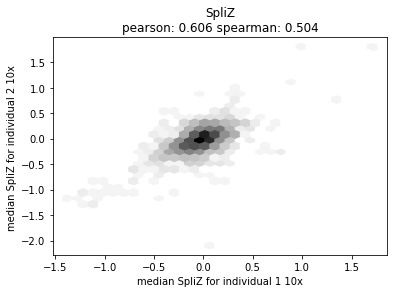

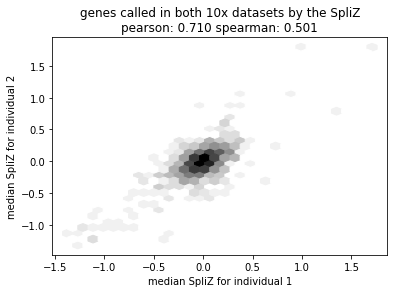

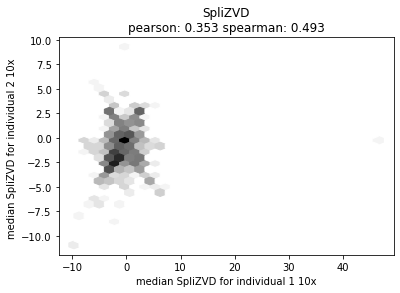

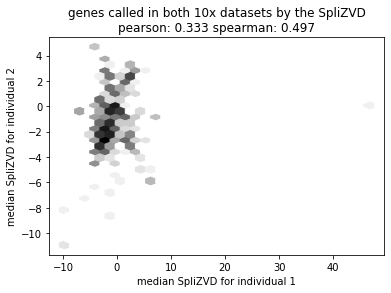

In [43]:

zcol_dict = {"scZ" : "SpliZ", "svd_z0" : "SpliZVD"}
for z_col in ["scZ","svd_z0"]:
#   plt.plot(merged["median_{}_P2".format(z_col)],merged["median_{}_P3".format(z_col)],linestyle="",marker="o",alpha = 0.4)
  plt.hexbin(merged["median_{}_P2".format(z_col)],merged["median_{}_P3".format(z_col)],gridsize=30,cmap="Greys",bins="log")

  plt.title("{}\npearson: {:.3f} spearman: {:.3f}".format(zcol_dict[z_col],merged["median_{}_P2".format(z_col)].corr(merged["median_{}_P3".format(z_col)],method="pearson"),merged["median_{}_P2".format(z_col)].corr(merged["median_{}_P3".format(z_col)],method="spearman")))
  plt.xlabel("median {} for individual 1 10x".format(zcol_dict[z_col]))
  plt.ylabel("median {} for individual 2 10x ".format(zcol_dict[z_col]))
  plt.savefig("{}{}_corr_all.png".format(outpath,z_col),bbox_inches="tight")
  plt.show()
  
  sub_df = merged[merged["geneR1A_uniq_P2"].isin(both_sig)]
  
  plt.hexbin(sub_df["median_{}_P2".format(z_col)],sub_df["median_{}_P3".format(z_col)],gridsize=30,cmap="Greys",bins="log")

  plt.title("genes called in both 10x datasets by the {}\npearson: {:.3f} spearman: {:.3f}".format(zcol_dict[z_col],sub_df["median_{}_P2".format(z_col)].corr(sub_df["median_{}_P3".format(z_col)],method="pearson"),sub_df["median_{}_P2".format(z_col)].corr(sub_df["median_{}_P3".format(z_col)],method="spearman")))
  plt.xlabel("median {} for individual 1".format(zcol_dict[z_col]))
  plt.ylabel("median {} for individual 2".format(zcol_dict[z_col]))
  plt.savefig("{}{}_corr_sig.png".format(outpath,z_col),bbox_inches="tight")

  plt.show()
  

HLCA4_P2_10x_with_postprocessing_lung_sharedjuncs_sharedonts
HLCA_smartseq_P2_with_postprocessing_sharedjuncs_sharedonts


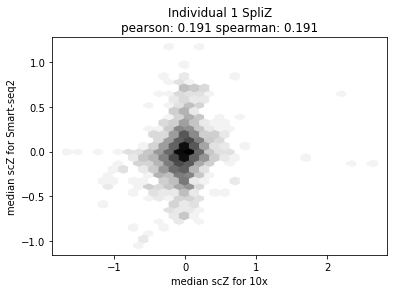

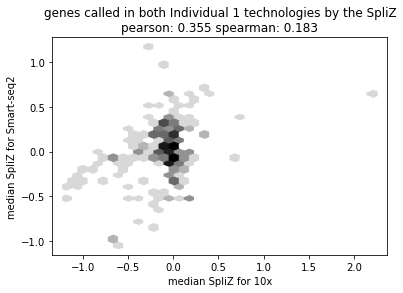

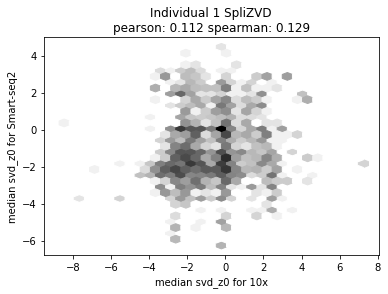

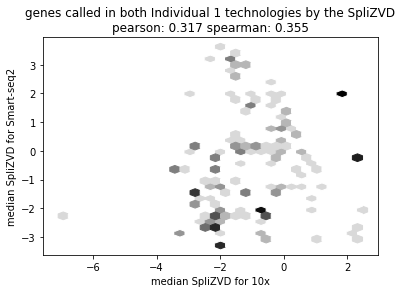

HLCA4_P3_10x_with_postprocessing_lung_sharedjuncs_sharedonts
HLCA_smartseq_P3_with_postprocessing_sharedjuncs_sharedonts


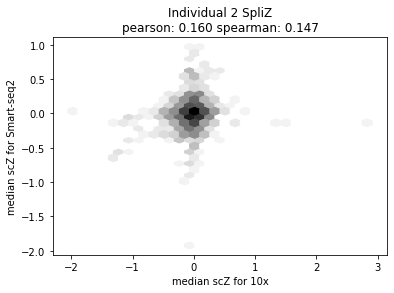

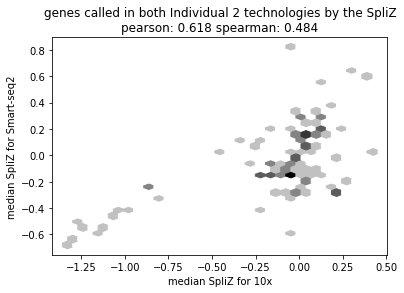

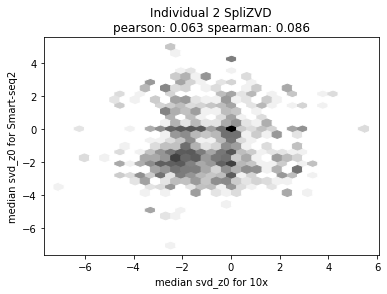

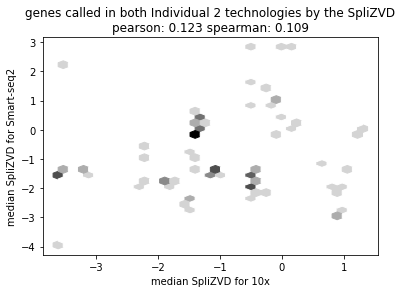

In [46]:
suffix = "_sharedjuncs_sharedonts"
ind_dict = {"P2" : "Individual 1", "P3" : "Individual 2"}
for ind in ["P2","P3"]:
  dfs = []
  sig_genes = []
  datanames = ["HLCA4_{}_10x_with_postprocessing_lung{}".format(ind,suffix),"HLCA_smartseq_{}_with_postprocessing{}".format(ind,suffix)]
  for dataname in datanames:
    print(dataname)
    df = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(in_path, dataname),columns=["ontology","geneR1A_uniq","scZ","svd_z0","svd_z1","svd_z2","cell_gene"])
    sig = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/scripts/output/variance_adjusted_permutations/{}_pvals_100_S_0.1_z_0.0_b_5.tsv".format(dataname),sep="\t")
    sig_genes.append(set(sig[sig["perm_pval_adj_scZ"] < 0.05]["geneR1A_uniq"].unique()))
    df = df.drop_duplicates("cell_gene")
    df["ontology_gene"] = df["ontology"] + df["geneR1A_uniq"]
    df["num_ont_gene"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell_gene"].nunique())
    df = df[df["num_ont_gene"] > 10]
    for z_col in z_cols:
      df["median_" + z_col] = df["ontology_gene"].map(df.groupby("ontology_gene")[z_col].median())
    df.drop_duplicates("ontology_gene")
    dfs.append(df)
  for i in range(len(dfs)):
    dfs[i] = dfs[i].drop_duplicates("ontology_gene")
  merged = dfs[0].merge(dfs[1],on="ontology_gene",suffixes=["_10x","_ss2"])
  both_sig = set.intersection(*sig_genes)
  for z_col in z_cols[:2]:
  #   plt.plot(merged["median_{}_P2".format(z_col)],merged["median_{}_P3".format(z_col)],linestyle="",marker="o",alpha = 0.4)
    plt.hexbin(merged["median_{}_10x".format(z_col)],merged["median_{}_ss2".format(z_col)],gridsize=30,cmap="Greys",bins="log")

    plt.title("{} {}\npearson: {:.3f} spearman: {:.3f}".format(ind_dict[ind],zcol_dict[z_col],merged["median_{}_10x".format(z_col)].corr(merged["median_{}_ss2".format(z_col)],method="pearson"),merged["median_{}_10x".format(z_col)].corr(merged["median_{}_ss2".format(z_col)],method="spearman")))
    plt.xlabel("median {} for 10x".format(z_col))
    plt.ylabel("median {} for Smart-seq2".format(z_col))
    plt.show()
    sub_df = merged[merged["geneR1A_uniq_10x"].isin(both_sig)]
    plt.hexbin(sub_df["median_{}_10x".format(z_col)],sub_df["median_{}_ss2".format(z_col)],gridsize=30,cmap="Greys",bins="log")

    plt.title("genes called in both {} technologies by the {}\npearson: {:.3f} spearman: {:.3f}".format(ind_dict[ind],zcol_dict[z_col],sub_df["median_{}_10x".format(z_col)].corr(sub_df["median_{}_ss2".format(z_col)],method="pearson"),sub_df["median_{}_10x".format(z_col)].corr(sub_df["median_{}_ss2".format(z_col)],method="spearman")))
    plt.xlabel("median {} for 10x".format(zcol_dict[z_col]))
    plt.ylabel("median {} for Smart-seq2".format(zcol_dict[z_col]))
    plt.savefig("{}{}_corr_sig_{}.png".format(outpath,ind,z_col),bbox_inches="tight")
    plt.show()

## Histograms of SpliZ values


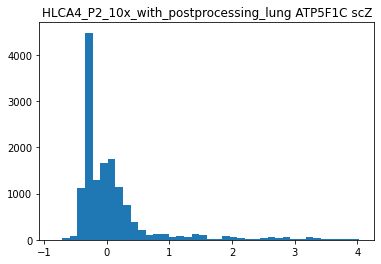

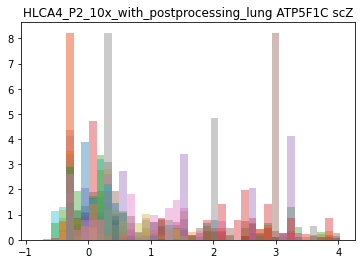

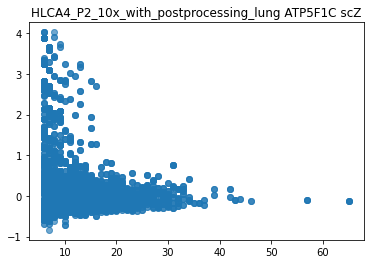

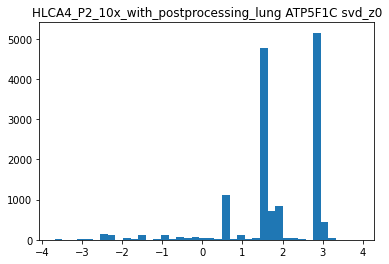

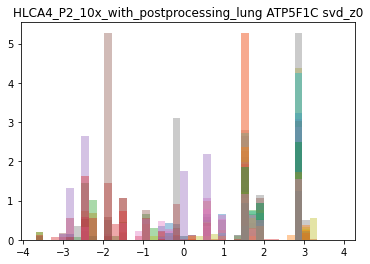

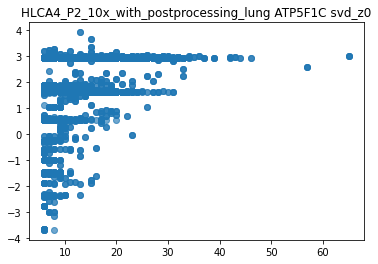

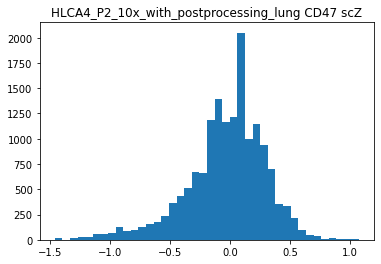

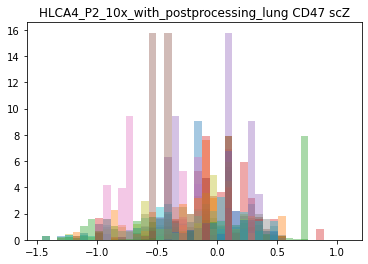

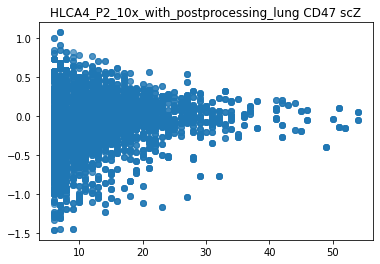

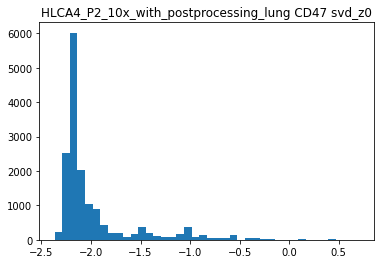

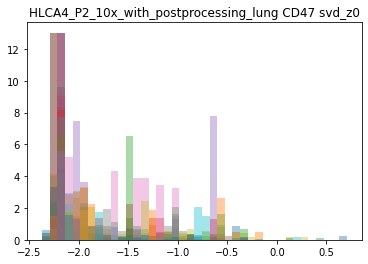

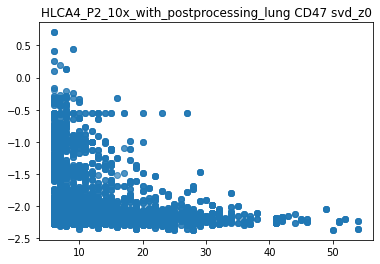

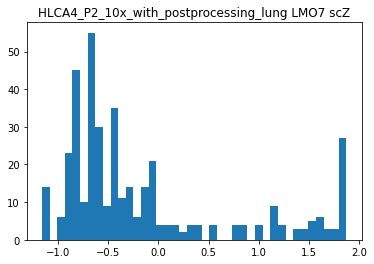

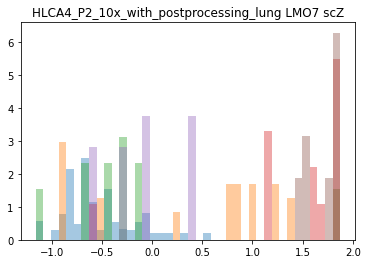

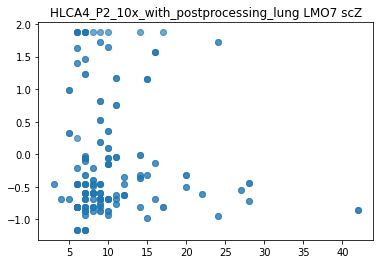

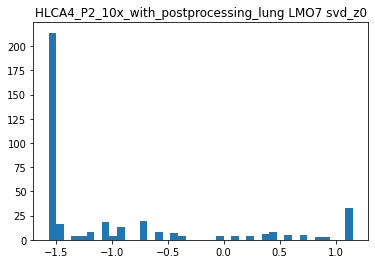

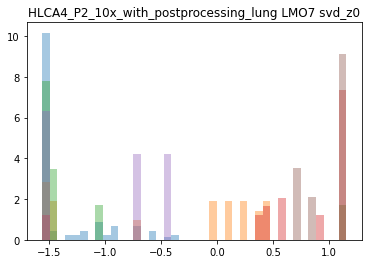

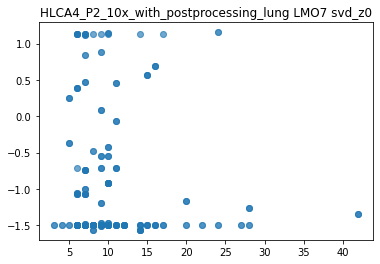

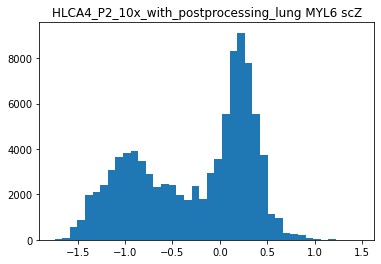

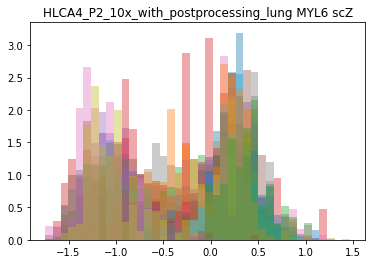

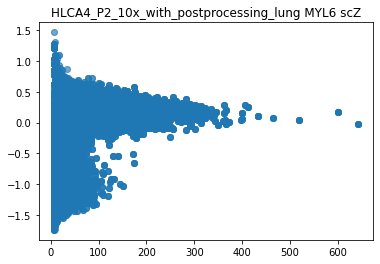

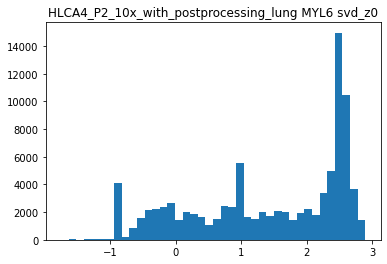

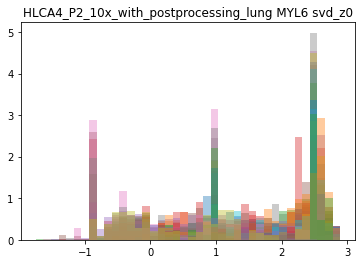

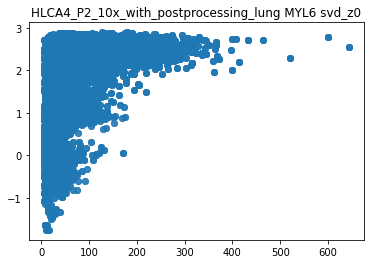

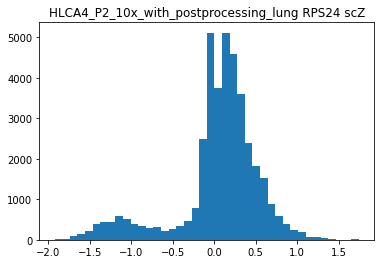

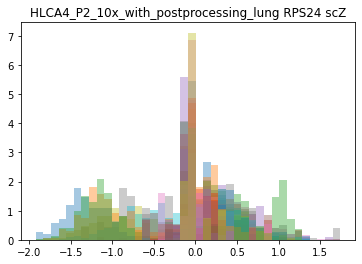

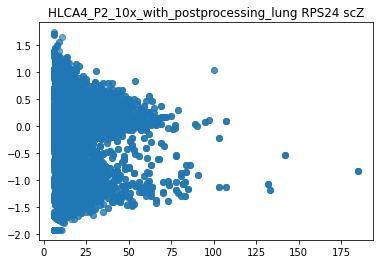

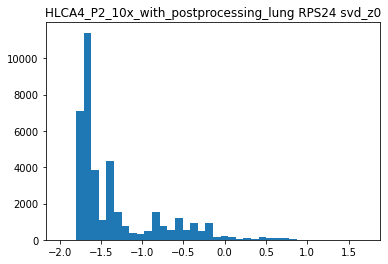

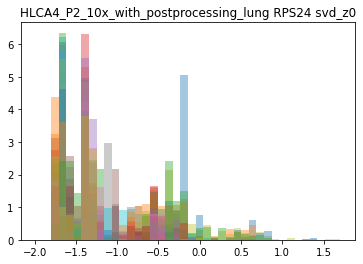

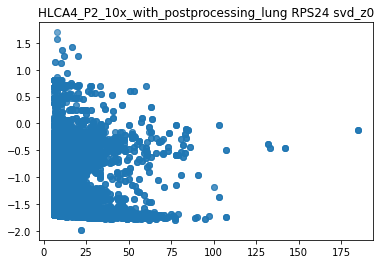

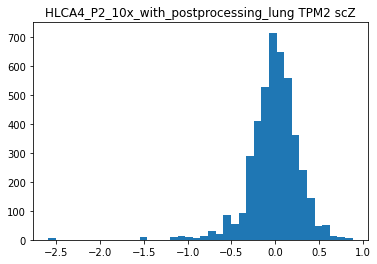

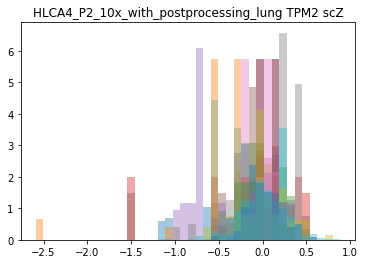

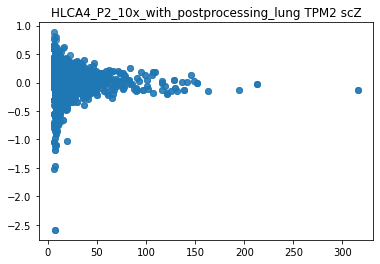

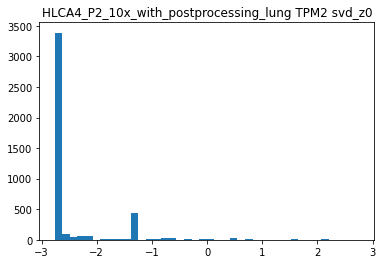

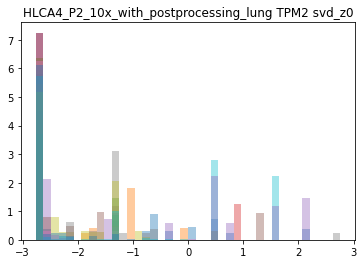

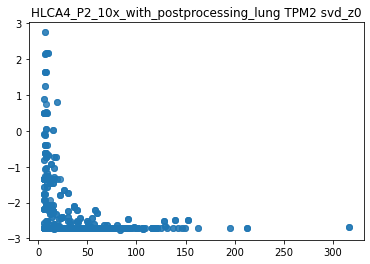

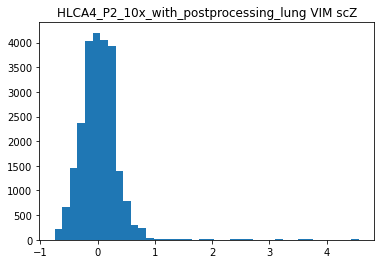

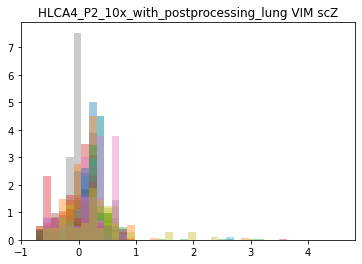

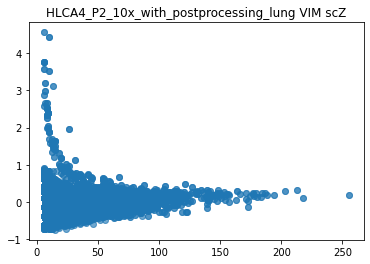

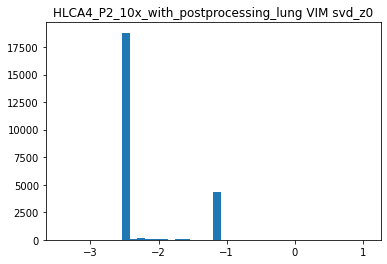

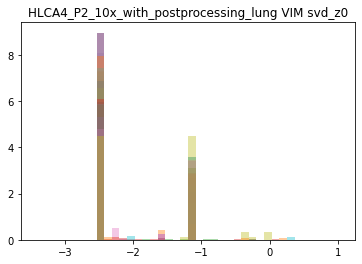

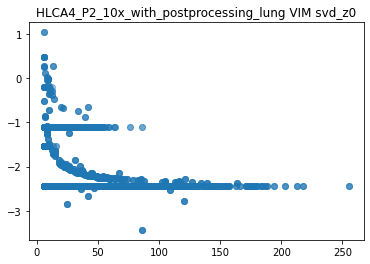

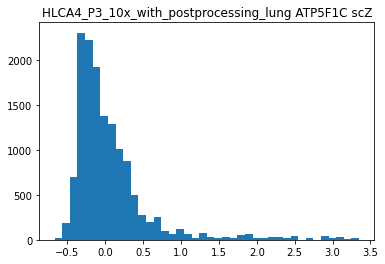

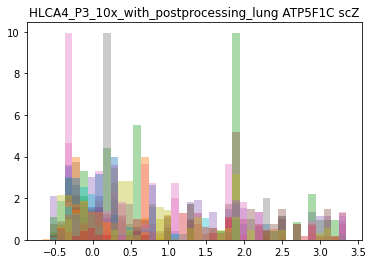

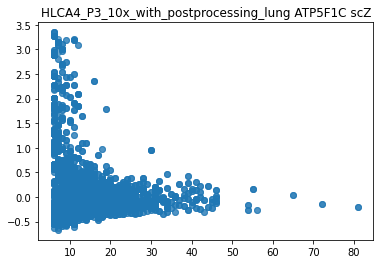

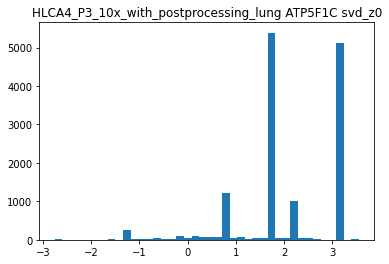

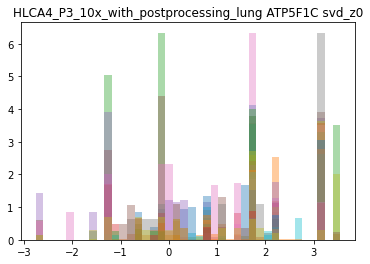

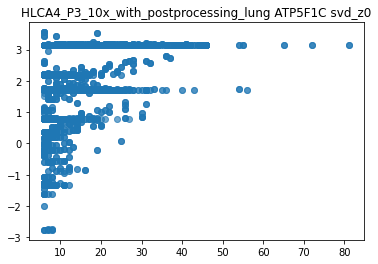

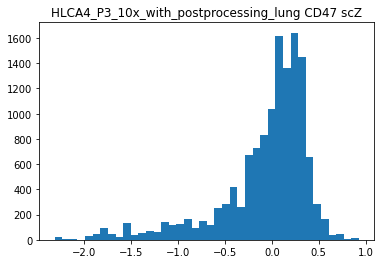

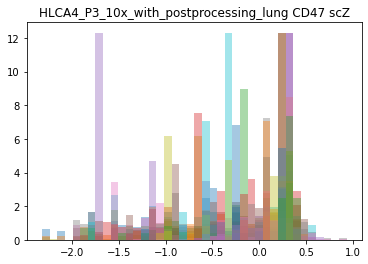

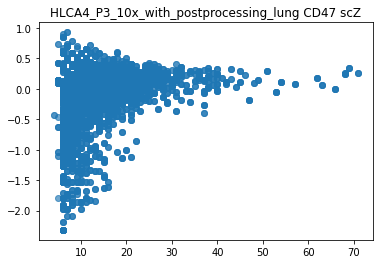

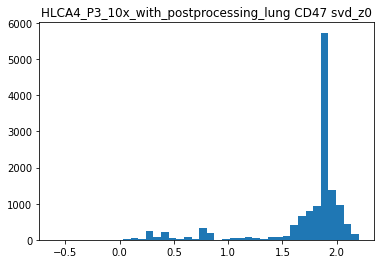

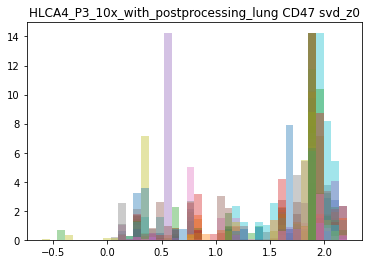

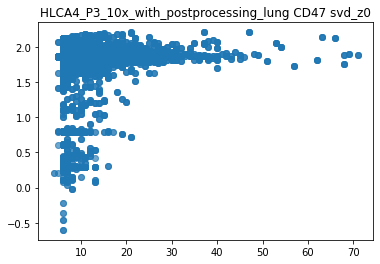

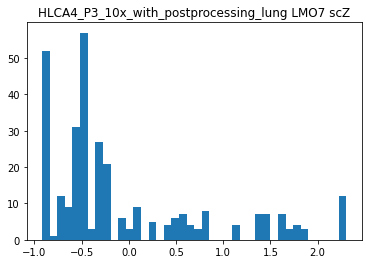

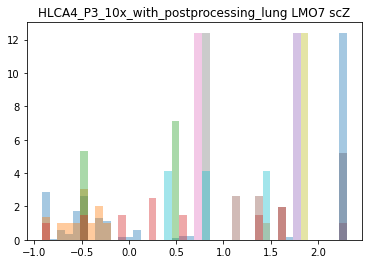

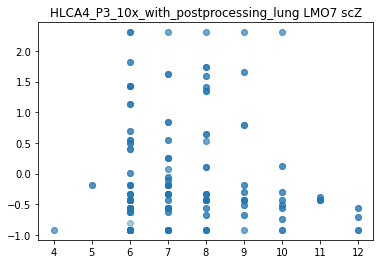

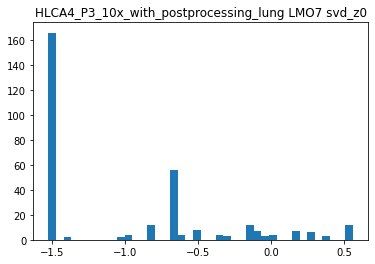

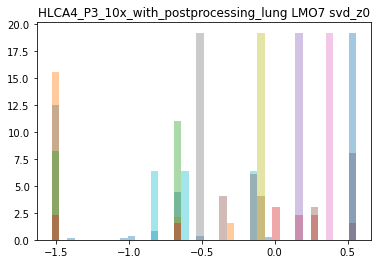

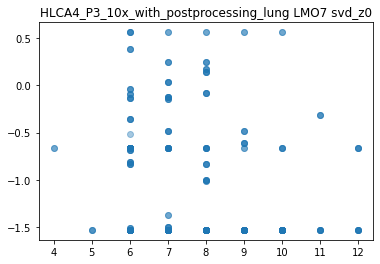

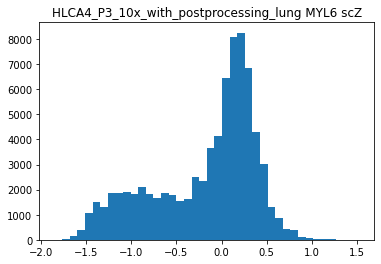

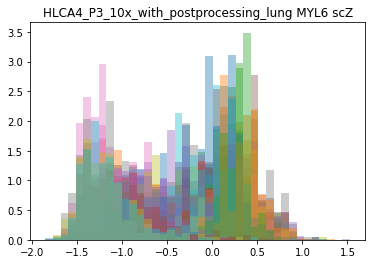

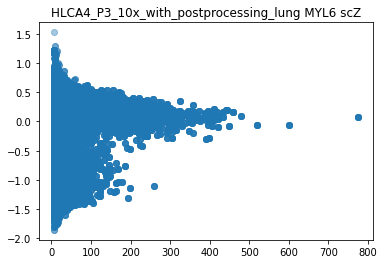

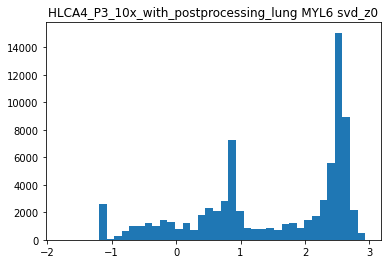

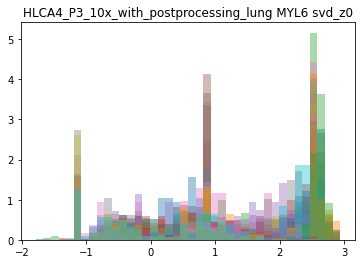

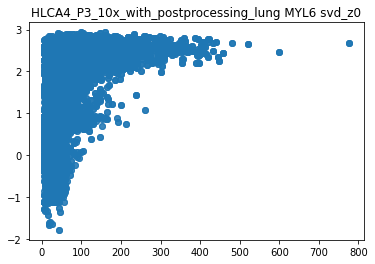

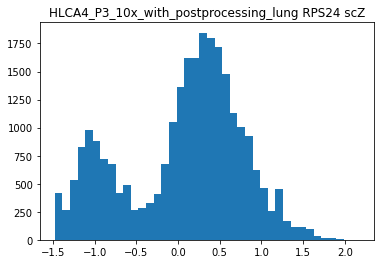

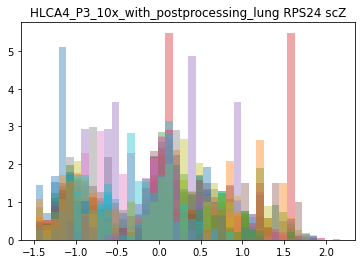

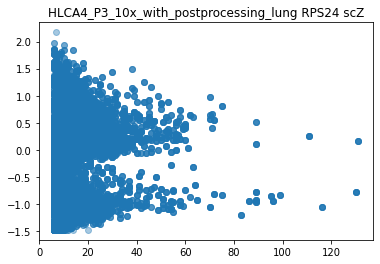

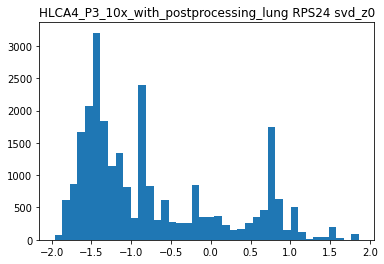

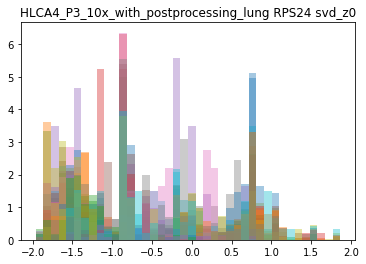

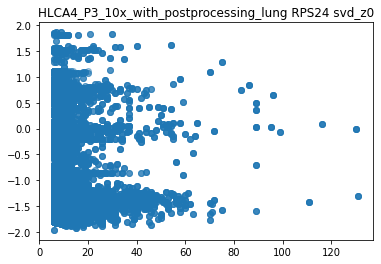

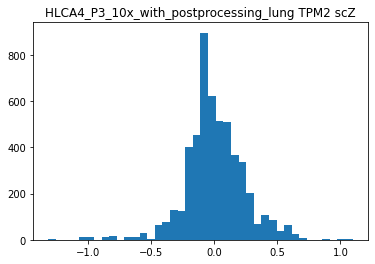

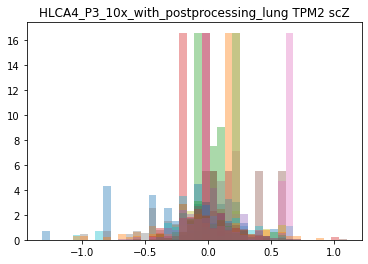

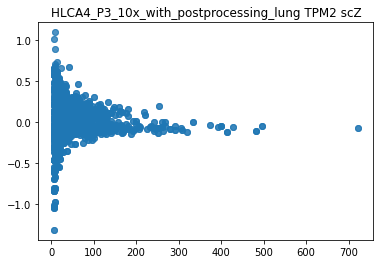

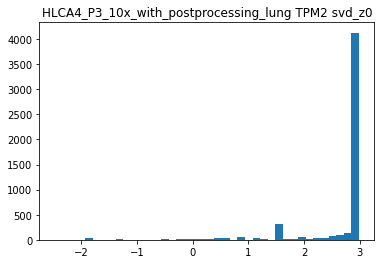

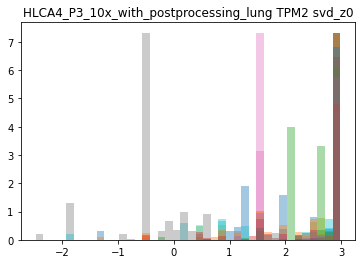

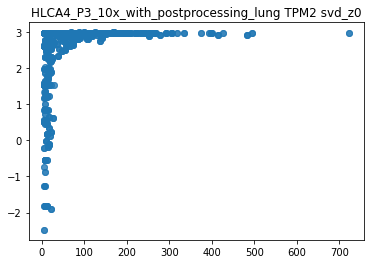

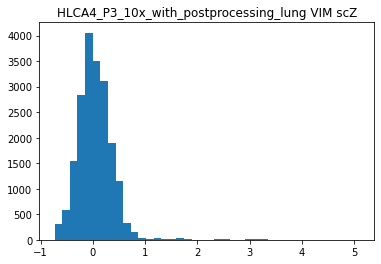

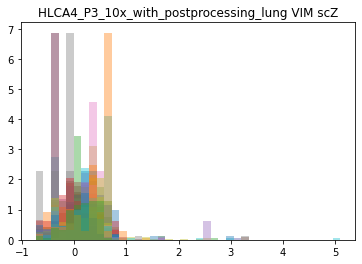

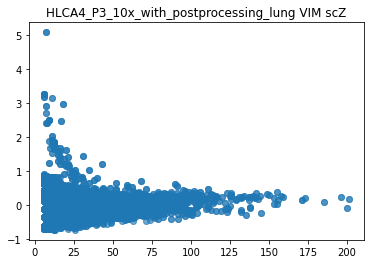

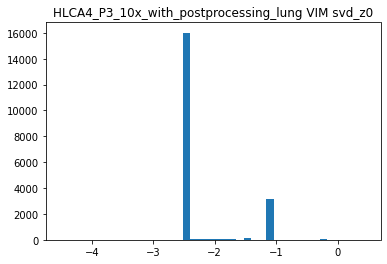

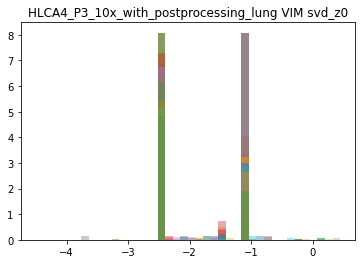

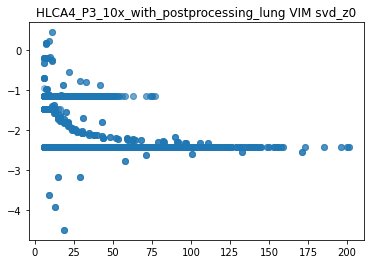

In [10]:
genes = ["MYL6","ATP5F1C","CD47","LMO7","TPM2", "RPS24","VIM"]
z_path = "/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/scripts/output/rijk_zscore/"
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
z_cols = ["scZ","svd_z0"]

for dataname in datanames:
  df = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(z_path,dataname),columns=["cell","cell_gene","geneR1A_uniq","numReads","ontology"] + z_cols)
  df = df[df["geneR1A_uniq"].isin(genes)]
  df["n.g"] = df.groupby("cell_gene")["numReads"].transform("sum")
  for gene, gene_df in df.groupby("geneR1A_uniq"):
    gene_df.drop_duplicates("cell")
    for z_col in z_cols:
      _, bins,_ = plt.hist(gene_df[z_col],40)
      plt.title("{} {} {}".format(dataname,gene,z_col))
      plt.show()
      
      for ont, ont_df in gene_df.groupby("ontology"):
        plt.hist(ont_df[z_col],bins = bins,density=True,alpha = 0.4)
      plt.title("{} {} {}".format(dataname,gene,z_col))
      plt.show()
      plt.plot(gene_df["n.g"],gene_df[z_col],marker="o",linestyle="",alpha = 0.4)
      plt.title("{} {} {}".format(dataname,gene,z_col))
      plt.show()

In [6]:
data_path = "/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/data/"
ind = "P2"
dataname = "HLCA4_{}_10x_with_postprocessing_lung".format(ind)
ind_dict = {"P2" : "Individual 1", "P3" : "Individual 2"}
df = pd.read_parquet("{}{}.pq".format(data_path,dataname),columns=["cell","numReads","tissue","compartment","free_annotation","geneR1A_uniq"])

In [8]:
df["cell type"] = df["tissue"] + df["compartment"] + df["free_annotation"]

In [9]:
df["number of spliced reads per cell"] = df.groupby("cell")["numReads"].transform("sum")

In [10]:
df["number of genes with detected splicing\nper cell"] = df["cell"].map(df.groupby("cell")["geneR1A_uniq"].nunique())

In [11]:
df = df.drop_duplicates("cell")

In [13]:
df["med_numreads"] = df["cell type"].map(df.groupby("cell type")["number of spliced reads per cell"].median())

In [14]:
df = df.sort_values("med_numreads")

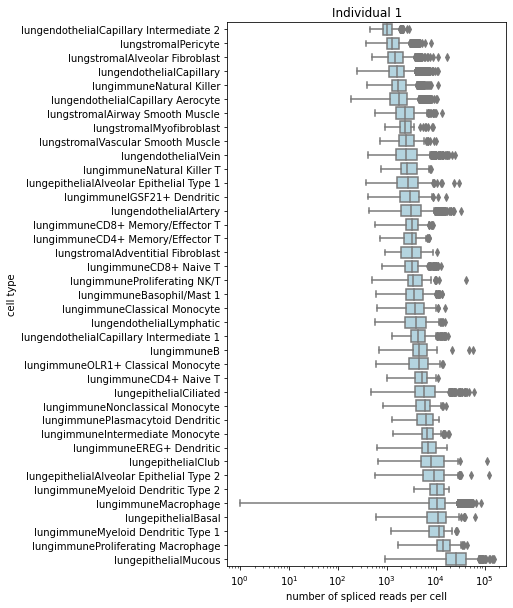

In [21]:
f, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=df, x="number of spliced reads per cell",y="cell type",color="lightblue")
plt.title(ind_dict[ind])
plt.xscale("log")
plt.savefig("{}{}_numreads_percell.png".format(outpath,ind),bbox_inches="tight")

plt.show()

In [ ]:
# df["med_numreads"] = df["cell type"].map(df.groupby("cell type")["number of reads per cell"].median())

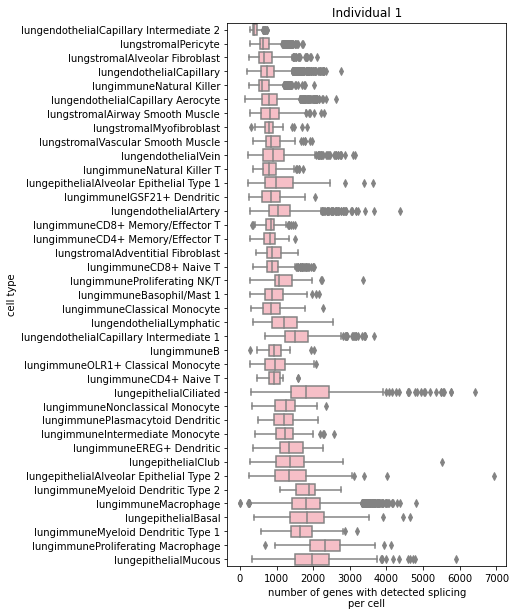

In [23]:
f, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=df, x="number of genes with detected splicing\nper cell",y="cell type",color="lightpink")
plt.title(ind_dict[ind])
# plt.xscale("log")
plt.savefig("{}{}_numgenes_percell.png".format(outpath,ind),bbox_inches="tight")

plt.show()

In [68]:
df["number of cells"] = df["cell type"].map(df.groupby("cell type")["cell"].nunique())

In [69]:
df = df.drop_duplicates("cell type")
df = df.sort_values("number of cells")

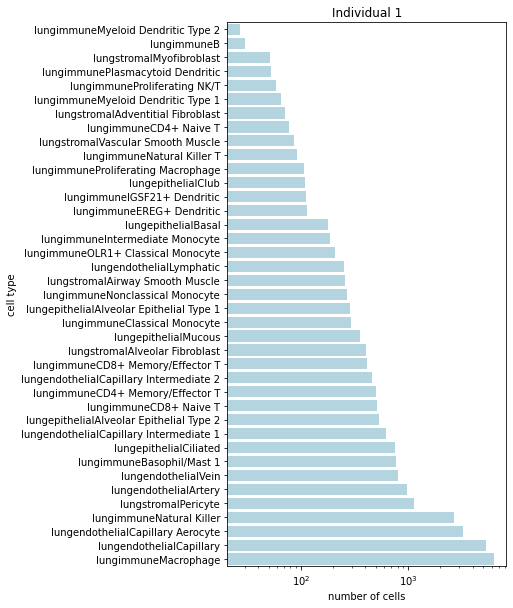

In [70]:
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(x="number of cells",y="cell type",data=df,color="lightblue")
plt.title(ind_dict[ind])
plt.xscale("log")
plt.savefig("{}{}_numcells.png".format(outpath,ind),bbox_inches="tight")
plt.show()